In [3]:
from helpers import *
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
device = 'cuda' #I am using my gpu

transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = MNIST(root='../mnist_data', train=True, download=True, transform=transform)
img,_ = train_dataset[0]

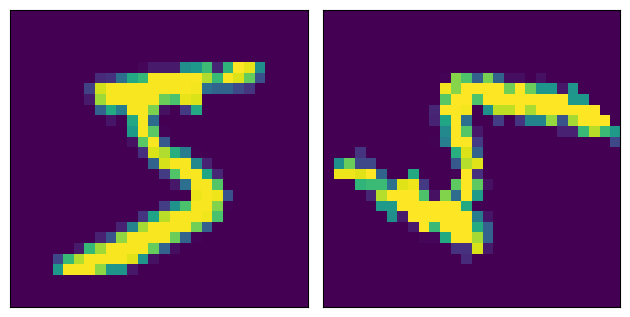

In [4]:
# testing with rotation
rotater = transforms.RandomRotation(degrees=(0,180))
rotated_img = rotater(img)
imgs = [img, rotated_img]
plot(imgs)

In [5]:
# Relabel and move
CR = img.to(device)
CT = rotated_img.to(device)

# Fine level of mesh - explodes the computational complexity the finer you go
gridsize = 200
# Creating the mesh and move
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize), 
    torch.linspace(-1,1,gridsize)), dim=-1).reshape(-1,2).to(device)

# Approximating velocity function with neural network
input_dim = 3
hidden_dim = 32
output_dim = 2
v_net = VelocityFieldNN(input_dim, hidden_dim, output_dim).to(device)

# Adam optimizer works well with little tuning I have noticed
optimizer = optim.Adam(v_net.parameters(), lr=0.005)

num_epochs = 400
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(v_net, x, CR, CT, device)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")

/home/warin/miniconda3/envs/ml-env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0, Loss: 0.05998799949884415
Epoch 1, Loss: 0.056166909635066986
Epoch 2, Loss: 0.054210443049669266
Epoch 3, Loss: 0.05224406719207764
Epoch 4, Loss: 0.04992111772298813
Epoch 5, Loss: 0.047190360724925995
Epoch 6, Loss: 0.044295527040958405
Epoch 7, Loss: 0.04173753038048744
Epoch 8, Loss: 0.03959207236766815
Epoch 9, Loss: 0.037619367241859436
Epoch 10, Loss: 0.035794682800769806
Epoch 11, Loss: 0.03415277227759361
Epoch 12, Loss: 0.03247978910803795
Epoch 13, Loss: 0.03048308566212654
Epoch 14, Loss: 0.028360893949866295
Epoch 15, Loss: 0.02626093290746212
Epoch 16, Loss: 0.024239003658294678
Epoch 17, Loss: 0.022468145936727524
Epoch 18, Loss: 0.020710734650492668
Epoch 19, Loss: 0.01896636374294758
Epoch 20, Loss: 0.01758316345512867
Epoch 21, Loss: 0.016385527327656746
Epoch 22, Loss: 0.015350686386227608
Epoch 23, Loss: 0.014237884432077408
Epoch 24, Loss: 0.013195033185184002
Epoch 25, Loss: 0.01208015251904726
Epoch 26, Loss: 0.011088885366916656
Epoch 27, Loss: 0.01025

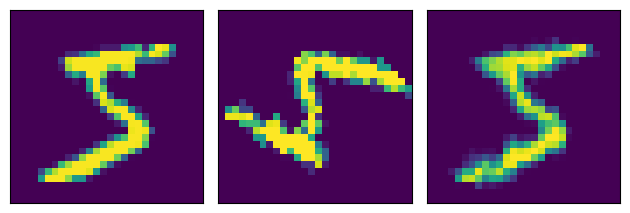

In [6]:
# now lets see what the transform is
# at this point v_net should be optimized

# move back to cpu
v_net = v_net.to('cpu')

# make the sampling grid the same size as CR and CT
gridsize = img.shape[1]
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize),
    torch.linspace(-1,1,gridsize),
), dim=-1).reshape(-1,2)

# Solve the ODE
def odefunc(t, z):
    return v_net(z, t)
t = torch.tensor([0.0, 1.0]) 
z_T = odeint(odefunc, x, t)[-1] # Take the solution at t=1

# Solve the inverse ODE
def inv_odefunc(t, z):
    return -v_net(z, t)
z_inv_T = odeint(inv_odefunc, z_T, torch.flip(t, dims=[0]))[0] #take the solution at t=0
CT_z_inv_T = bilinear_interpolation(CT, z_inv_T, device='cpu').view(1, gridsize, gridsize).transpose(1,2)

imgs = [img, rotated_img, CT_z_inv_T]
# CR - CT - T(y(x))
plot(imgs)

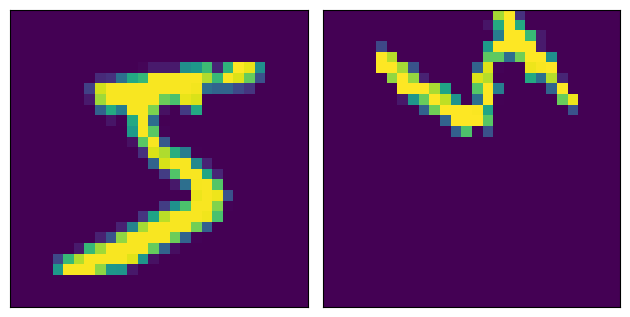

In [5]:
# Random affine transform
affine_transfomer = transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_img = affine_transfomer(img)
plot([img, affine_img])

In [6]:
# Relabel and move
CR = img.to(device)
CT = affine_img.to(device)

# Fine level of mesh - explodes the computational complexity the finer you go
gridsize = 200
# Creating the mesh and move
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize), 
    torch.linspace(-1,1,gridsize)), dim=-1).reshape(-1,2).to(device)

# Approximating velocity function with neural network
input_dim = 3
hidden_dim = 32
output_dim = 2
v_net = VelocityFieldNN(input_dim, hidden_dim, output_dim).to(device)

# Adam optimizer works well with little tuning I have noticed
optimizer = optim.Adam(v_net.parameters(), lr=0.005)

num_epochs = 400
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(v_net, x, CR, CT, device)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")

/home/warin/miniconda3/envs/ml-env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0, Loss: 0.06403586268424988
Epoch 1, Loss: 0.060539085417985916
Epoch 2, Loss: 0.0574764758348465
Epoch 3, Loss: 0.055115893483161926
Epoch 4, Loss: 0.053646739572286606
Epoch 5, Loss: 0.052948929369449615
Epoch 6, Loss: 0.052450742572546005
Epoch 7, Loss: 0.05180446803569794
Epoch 8, Loss: 0.0509047731757164
Epoch 9, Loss: 0.05012526735663414
Epoch 10, Loss: 0.04981701448559761
Epoch 11, Loss: 0.04981785640120506
Epoch 12, Loss: 0.049769096076488495
Epoch 13, Loss: 0.04953252896666527
Epoch 14, Loss: 0.04919269308447838
Epoch 15, Loss: 0.0487564392387867
Epoch 16, Loss: 0.04832494258880615
Epoch 17, Loss: 0.048004575073719025
Epoch 18, Loss: 0.0479084812104702
Epoch 19, Loss: 0.04795270785689354
Epoch 20, Loss: 0.047867320477962494
Epoch 21, Loss: 0.0475187711417675
Epoch 22, Loss: 0.04708744212985039
Epoch 23, Loss: 0.04671569541096687
Epoch 24, Loss: 0.04650674760341644
Epoch 25, Loss: 0.04637878015637398
Epoch 26, Loss: 0.04622572287917137
Epoch 27, Loss: 0.04597943648695946

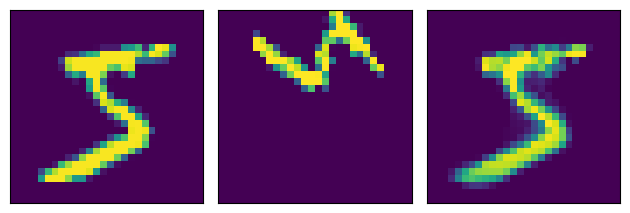

In [7]:

v_net = v_net.to('cpu')

# make the sampling grid the same size as CR and CT
gridsize = img.shape[1]
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize),
    torch.linspace(-1,1,gridsize),
), dim=-1).reshape(-1,2)

# Solve the ODE
def odefunc(t, z):
    return v_net(z, t)
t = torch.tensor([0.0, 1.0]) 
z_T = odeint(odefunc, x, t)[-1] # Take the solution at t=1

# Solve the inverse ODE
def inv_odefunc(t, z):
    return -v_net(z, t)
z_inv_T = odeint(inv_odefunc, z_T, torch.flip(t, dims=[0]))[0] #take the solution at t=0
CT_z_inv_T = bilinear_interpolation(CT, z_inv_T, device='cpu').view(1, gridsize, gridsize).transpose(1,2)

imgs = [img, affine_img, CT_z_inv_T]
# CR - CT - T(y(x))
plot(imgs)